In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections import defaultdict

from sklearn import model_selection, ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.utils.multiclass import unique_labels

# model saving
import pickle 
from joblib import Parallel, delayed
import joblib

# heatmap
import seaborn as sn

from matplotlib import pyplot

# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
import keras 
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Activation, Bidirectional, InputLayer, BatchNormalization, Reshape, AveragePooling1D, MaxPool1D, Multiply, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


2023-03-23 20:42:04.585346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 20:42:04.756653: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-23 20:42:04.779796: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-03-23 20:42:04.779814: I tensorflow/compiler/xla/stream_execut

In [ ]:
pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# data process

In [ ]:
# !gdown 1BQ_5BnEJfpR0a4K1GJB99RVR2Q63eXIF

Downloading...
From: https://drive.google.com/uc?id=1BQ_5BnEJfpR0a4K1GJB99RVR2Q63eXIF
To: /content/tumor_gene_Symbol_dataset.csv
100% 1.38G/1.38G [00:10<00:00, 127MB/s]


In [2]:
gene_symbol_mapping= pd.read_csv("./tumor_gene_Symbol_dataset.csv", sep=',')
gene_symbol_mapping = gene_symbol_mapping.sort_values(by=['Unnamed: 0'])
gene_symbol_mapping= gene_symbol_mapping.set_index('Unnamed: 0')
gene_symbol_mapping = gene_symbol_mapping[gene_symbol_mapping['cancer type abbreviation'].notna()]

gene_symbol_mapping

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,5.2698,3.0270,3.8876,-9.9658,9.0048,5.5361,1.1960,-2.3147,-2.2447,1.9452,...,2.2113,-1.3183,-0.4325,3.2143,4.6247,-9.9658,GBM,78.0,MALE,WHITE
TCGA-02-0055-01,4.9026,2.9243,3.0498,-5.5735,10.4794,5.5877,1.8363,-0.2671,-0.1504,0.0014,...,1.8996,-5.0116,-1.3548,4.1716,4.2563,-9.9658,GBM,62.0,FEMALE,WHITE
TCGA-02-2483-01,5.1260,2.8076,3.5754,-9.9658,10.5954,4.8500,0.5069,-0.6643,-4.6082,2.6940,...,0.0580,-9.9658,-4.6082,2.1988,4.2412,-9.9658,GBM,43.0,MALE,ASIAN
TCGA-02-2485-01,5.9409,3.5224,3.9746,-6.5064,9.8786,5.4383,0.2522,-0.9686,-1.5522,2.8158,...,1.1184,-5.5735,1.1250,3.0791,4.7132,-9.9658,GBM,53.0,MALE,BLACK OR AFRICAN AMERICAN
TCGA-04-1331-01,4.7005,1.3567,5.1639,-1.1811,8.7960,3.7400,2.5137,3.0706,-0.7108,0.9115,...,2.3394,-5.5735,-4.2934,0.9642,4.8218,-9.9658,OV,78.0,FEMALE,WHITE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZS-A9CF-02,3.3535,-0.2159,3.1095,-9.9658,9.4021,4.2743,-5.5735,-4.2934,-1.7322,-0.2159,...,0.8647,6.3266,-0.6416,-0.2159,3.3307,-9.9658,LIHC,64.0,MALE,WHITE
TCGA-ZS-A9CG-01,3.5262,0.6699,2.4359,-9.9658,8.7991,3.8330,-3.3076,-2.9324,0.1257,-1.8314,...,2.0183,5.8352,-2.2447,-0.5332,3.4384,-9.9658,LIHC,55.0,MALE,WHITE
TCGA-ZT-A8OM-01,6.0219,-0.1665,2.6962,-4.0350,12.3251,3.7720,-0.9971,-1.5105,-1.9379,-0.9686,...,-1.5522,-2.4659,-0.4921,2.9729,6.6918,-9.9658,THYM,73.0,FEMALE,WHITE


In [3]:
cancer_names= gene_symbol_mapping['cancer type abbreviation'].unique()

In [4]:
gene_symbol_mapping['age_at_initial_pathologic_diagnosis']= gene_symbol_mapping['age_at_initial_pathologic_diagnosis'].astype(str)

d = defaultdict(LabelEncoder)
columns_to_encode = [
    "cancer type abbreviation",
    "age_at_initial_pathologic_diagnosis",
    "gender",
    "race"
]

gene_symbol_mapping.loc[:,columns_to_encode] = gene_symbol_mapping.loc[:,columns_to_encode].apply(lambda x: d[x.name].fit_transform(x.fillna('0')))
gene_symbol_mapping.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9784 entries, TCGA-02-0047-01 to TCGA-ZX-AA5X-01
Columns: 19242 entries, RAB4B to race
dtypes: float64(19238), int64(4)
memory usage: 1.4+ GB


In [5]:
cancer_nums= gene_symbol_mapping['cancer type abbreviation'].unique()
cancer_name_num_dict = dict(zip(cancer_nums, cancer_names))


In [6]:
gene_symbol_mapping_dummies = gene_symbol_mapping.copy()
gene_symbol_mapping_dummies = pd.get_dummies(gene_symbol_mapping_dummies)

X = gene_symbol_mapping_dummies.copy()
y = gene_symbol_mapping_dummies['cancer type abbreviation'].copy()

# load the datasets

In [ ]:
# !gdown 15sUdoFB8qTwcsGyPky2CmDwmRi5f5KZP

Downloading...
From: https://drive.google.com/uc?id=15sUdoFB8qTwcsGyPky2CmDwmRi5f5KZP
To: /content/data.zip
100% 2.42G/2.42G [00:18<00:00, 133MB/s]


In [8]:
!unzip ./data.zip

Archive:  ./data.zip
replace test_split_1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
columns_to_drop = [
    "cancer type abbreviation",
    "age_at_initial_pathologic_diagnosis",
    "gender",
    "race"
]

# 1D CNN

In [10]:
pip install tensorflow-addons


Note: you may need to restart the kernel to use updated packages.


In [11]:
from tensorflow_addons.layers import WeightNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.normalization.batch_normalization import BatchNormalization
import tensorflow
import tensorflow as tf

/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [12]:
def create_cnn(maxlen, num_classes):
    inp = Input(shape=(maxlen,))

    x = BatchNormalization()(inp)
    x = Dropout(0.3)(x)
    x = WeightNormalization(Dense(4096))(x)
    x = Reshape((256, 16))(x)

    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = WeightNormalization(Conv1D(filters = 64, kernel_size = 3, activation = 'relu', use_bias = False, padding = 'SAME'))(x)
    x = AveragePooling1D(pool_size = 2)(x)
    xs = x

    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = WeightNormalization(Conv1D(filters = 64, kernel_size = 3, activation = 'relu', use_bias = True, padding = 'SAME'))(x)

    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = WeightNormalization(Conv1D(filters = 64, kernel_size = 3, activation = 'relu', use_bias = True, padding = 'SAME'))(x)
    x = Multiply()([x, xs])
    x = MaxPool1D(pool_size = 4, strides = 2)(x)
    x = Flatten()(x)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(512)(x)
    x = Activation('relu')(x)
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    # x = Activation('relu')(x)
    # x = Dense(64)(x)
    x = Activation('relu')(x)
    x = Dense(num_classes)(x)

    out = Activation('softmax')(x)


    model = Model(inputs=inp, outputs=out)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate = 0.001), metrics=['accuracy'])
    model.summary()
    return model

In [13]:
maxlen=19238
num_classes=33

In [14]:
model = create_cnn(19238, 33)

2023-03-23 20:49:32.288934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 20:49:32.289082: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 20:49:32.289191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-03-23 20:49:32.289353: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIB

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 19238)]      0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 19238)       76952       ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 19238)        0           ['batch_normalization[0][0

In [15]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, min_delta=1e-5)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=8, verbose=1, min_delta=1e-5)


callbacks_list = [early_stop, reduce_lr]

# Conf Matrix

In [16]:
def plot_conf_matrix(cm, y_test):
    labels=unique_labels(y_test)
    cancer_names=[]
    for i in labels:
        if i in cancer_name_num_dict.keys():
            cancer_names.append(cancer_name_num_dict[i])
    
    column= [f'Predict_{cancer_name}' for cancer_name in cancer_names]
    indices= [f'Actual_{cancer_name}' for cancer_name in cancer_names]
    
    table= pd.DataFrame(cm, columns=column, index=indices)
    
    fig, ax = pyplot.subplots(figsize=(12,12))         # Sample figsize in inches

    return sn.heatmap(table, annot=True, fmt="d",  linewidths=.5, ax=ax)

# 1

In [17]:
test_split_1= pd.read_csv("./test_split_1.csv", sep=',')
test_split_1

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,5.2698,3.0270,3.8876,-9.9658,9.0048,5.5361,1.1960,-2.3147,-2.2447,1.9452,...,2.2113,-1.3183,-0.4325,3.2143,4.6247,-9.9658,8,64,1,5
1,4.9026,2.9243,3.0498,-5.5735,10.4794,5.5877,1.8363,-0.2671,-0.1504,0.0014,...,1.8996,-5.0116,-1.3548,4.1716,4.2563,-9.9658,8,48,0,5
2,5.1260,2.8076,3.5754,-9.9658,10.5954,4.8500,0.5069,-0.6643,-4.6082,2.6940,...,0.0580,-9.9658,-4.6082,2.1988,4.2412,-9.9658,8,29,1,2
3,5.9409,3.5224,3.9746,-6.5064,9.8786,5.4383,0.2522,-0.9686,-1.5522,2.8158,...,1.1184,-5.5735,1.1250,3.0791,4.7132,-9.9658,8,39,1,3
4,4.7005,1.3567,5.1639,-1.1811,8.7960,3.7400,2.5137,3.0706,-0.7108,0.9115,...,2.3394,-5.5735,-4.2934,0.9642,4.8218,-9.9658,19,64,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,4.9878,3.2915,3.6939,-4.0350,10.2184,4.4437,-6.5064,-5.0116,-9.9658,0.1648,...,1.5064,-9.9658,-4.0350,1.5854,4.9132,-9.9658,32,64,1,5
1953,5.5420,2.5213,3.8993,-5.5735,10.2946,4.6600,-9.9658,-4.0350,-2.6349,-0.8339,...,2.1147,-9.9658,-9.9658,-1.6394,5.3548,-9.9658,32,24,1,5
1954,4.9050,1.4441,3.9506,-9.9658,10.2031,5.0282,-9.9658,-3.6259,-2.8262,1.1117,...,2.2513,-9.9658,-6.5064,-0.2845,5.0618,-9.9658,32,23,0,5
1955,5.5305,3.3148,3.4752,-3.1714,10.2961,4.1828,-1.2142,-5.5735,-6.5064,0.1519,...,1.6234,-9.9658,-5.5735,2.0946,4.9778,-9.9658,32,46,1,5


In [18]:
test_split_1_dummies = test_split_1.copy()
test_split_1_dummies = pd.get_dummies(test_split_1_dummies)

X_test_1 = test_split_1_dummies.drop(columns_to_drop, axis=1).copy()
y_test_1 = test_split_1_dummies['cancer type abbreviation'].copy()

In [19]:
train_split_1= pd.read_csv("./train_split_1.csv", sep=',')
train_split_1

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,5.4680,3.5694,4.2126,-2.4659,9.0496,5.3636,0.6608,-0.6873,-2.6349,2.0946,...,1.0151,-3.6259,0.8805,4.2578,4.9308,-9.9658,8,46,1,5
1,5.4787,2.7422,3.7571,-1.8836,9.6983,5.7642,0.1903,-0.3022,-1.3921,1.8604,...,1.7702,-2.6349,0.8408,1.1512,4.2103,-9.9658,8,59,0,3
2,5.6994,3.0481,4.1094,-9.9658,9.9318,5.3155,1.8323,0.4967,-2.2447,1.3109,...,0.4967,-9.9658,-0.2498,3.5111,4.7587,-9.9658,8,39,1,5
3,6.2196,2.4985,3.8551,-3.4580,9.6547,5.2114,-2.3884,-1.8836,-1.5522,1.5366,...,1.9111,-2.6349,0.1124,3.3979,4.4784,-9.9658,8,55,1,5
4,6.0540,2.3760,3.6972,-6.5064,10.0772,4.8783,0.3231,0.7321,-2.5479,1.9527,...,0.2881,-9.9658,-0.1031,4.0926,4.6306,-9.9658,8,52,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7822,3.3535,-0.2159,3.1095,-9.9658,9.4021,4.2743,-5.5735,-4.2934,-1.7322,-0.2159,...,0.8647,6.3266,-0.6416,-0.2159,3.3307,-9.9658,15,50,1,5
7823,3.5262,0.6699,2.4359,-9.9658,8.7991,3.8330,-3.3076,-2.9324,0.1257,-1.8314,...,2.0183,5.8352,-2.2447,-0.5332,3.4384,-9.9658,15,41,1,5
7824,6.0219,-0.1665,2.6962,-4.0350,12.3251,3.7720,-0.9971,-1.5105,-1.9379,-0.9686,...,-1.5522,-2.4659,-0.4921,2.9729,6.6918,-9.9658,29,59,0,5
7825,5.0631,2.9784,3.5212,-5.5735,9.6838,5.0466,1.3956,-2.1140,-1.4699,0.3231,...,1.4704,-0.1031,-5.5735,2.4386,4.8530,-9.9658,4,38,1,5


In [20]:
train_split_1_dummies = train_split_1.copy()
train_split_1_dummies = pd.get_dummies(train_split_1_dummies)

X_train_1 = train_split_1_dummies.drop(columns_to_drop, axis=1).copy()
y_train_1 = train_split_1_dummies['cancer type abbreviation'].copy()

In [21]:
cnn_model_1 = model

In [22]:
training_history = cnn_model_1.fit(X_train_1, y_train_1, batch_size=64, 
          epochs=200, validation_split=0.2, shuffle = True, callbacks=callbacks_list)

Epoch 1/200
98/98 [==============================] - 56s 542ms/step - loss: 0.9575 - accuracy: 0.7398 - val_loss: 3.2875 - val_accuracy: 0.4100 - lr: 0.0010
Epoch 2/200
98/98 [==============================] - 52s 529ms/step - loss: 0.2602 - accuracy: 0.9219 - val_loss: 2.5055 - val_accuracy: 0.6814 - lr: 0.0010
Epoch 3/200
98/98 [==============================] - 52s 530ms/step - loss: 0.1965 - accuracy: 0.9375 - val_loss: 2.8520 - val_accuracy: 0.6922 - lr: 0.0010
Epoch 4/200
98/98 [==============================] - 52s 530ms/step - loss: 0.1440 - accuracy: 0.9537 - val_loss: 3.5148 - val_accuracy: 0.7401 - lr: 0.0010
Epoch 5/200
98/98 [==============================] - 52s 527ms/step - loss: 0.1101 - accuracy: 0.9647 - val_loss: 3.2246 - val_accuracy: 0.7337 - lr: 0.0010
Epoch 6/200
98/98 [==============================] - 52s 533ms/step - loss: 0.0852 - accuracy: 0.9708 - val_loss: 3.4754 - val_accuracy: 0.7382 - lr: 0.0010
Epoch 7/200
98/98 [==============================] - 52s 5

In [23]:
cnn_model_1.save('Stratified_1DCNN_1' + '.h5')

In [24]:
scoreSeg1 = cnn_model_1.evaluate(X_test_1, y_test_1, verbose= False)
print("Accuracy = ",scoreSeg1[1])

Accuracy =  0.9161982536315918


In [80]:
y_pred_1 = cnn_model_1.predict(X_test_1).round()

62/62 [==============================] - 4s 57ms/step


In [81]:
from sklearn.metrics import classification_report

In [85]:
print(classification_report(y_test_1, np.argmax(y_pred_1, axis = 1)))

              precision    recall  f1-score   support

           0       0.07      0.13      0.09        15
           1       0.96      0.99      0.98        81
           2       1.00      1.00      1.00       220
           3       0.98      0.98      0.98        61
           4       0.00      0.00      0.00         8
           5       0.93      0.91      0.92        58
           6       0.90      1.00      0.95         9
           7       1.00      0.97      0.99        36
           8       0.97      1.00      0.99        33
           9       0.99      0.98      0.99       104
          10       0.71      0.92      0.80        13
          11       0.96      0.92      0.94       106
          12       0.96      0.90      0.93        58
          13       1.00      1.00      1.00        35
          14       1.00      0.99      1.00       105
          15       0.97      1.00      0.99        74
          16       0.94      0.97      0.96       103
          17       0.96    

/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
cm1=(confusion_matrix(y_test_1, y_pred_1))

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [ ]:
plot_conf_matrix(cm1,y_test_1)

In [86]:
# make predictions for test data
# predictions_1 = [np.round(value) for value in y_pred_1]
# evaluate predictions
accuracy_1 = accuracy_score(y_test_1, y_pred_1)
print("Accuracy: %.2f%%" % (accuracy_1 * 100.0))

# precision tp / (tp + fp)
# precision = precision_score(y_test, predictions, average=None)
# print('Precision for every class: %f' % precision.astype(str))
precision_1 = precision_score(y_test_1, y_pred_1, average='macro')
print('Precision for all class: %f' % precision_1)

# recall: tp / (tp + fn)
recall_1 = recall_score(y_test_1, y_pred_1,average='macro')
print('Recall: %f' % recall_1)
# f1: 2 tp / (2 tp + fp + fn)
f1_1 = f1_score(y_test_1, y_pred_1, average='macro')
print('F1 score: %f' % f1_1)

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

# 2

In [35]:
test_split_2= pd.read_csv("./test_split_2.csv", sep=',')
test_split_2

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,5.4680,3.5694,4.2126,-2.4659,9.0496,5.3636,0.6608,-0.6873,-2.6349,2.0946,...,1.0151,-3.6259,0.8805,4.2578,4.9308,-9.9658,8,46,1,5
1,5.4787,2.7422,3.7571,-1.8836,9.6983,5.7642,0.1903,-0.3022,-1.3921,1.8604,...,1.7702,-2.6349,0.8408,1.1512,4.2103,-9.9658,8,59,0,3
2,5.6994,3.0481,4.1094,-9.9658,9.9318,5.3155,1.8323,0.4967,-2.2447,1.3109,...,0.4967,-9.9658,-0.2498,3.5111,4.7587,-9.9658,8,39,1,5
3,6.2196,2.4985,3.8551,-3.4580,9.6547,5.2114,-2.3884,-1.8836,-1.5522,1.5366,...,1.9111,-2.6349,0.1124,3.3979,4.4784,-9.9658,8,55,1,5
4,6.0540,2.3760,3.6972,-6.5064,10.0772,4.8783,0.3231,0.7321,-2.5479,1.9527,...,0.2881,-9.9658,-0.1031,4.0926,4.6306,-9.9658,8,52,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,5.7469,1.4547,4.4542,-4.2934,10.9842,4.8997,-2.8262,0.7832,-4.0350,1.4911,...,0.8164,-3.6259,0.2881,1.5115,5.9789,-9.9658,29,27,1,5
1953,6.1196,1.5514,3.9194,-3.8160,11.2873,4.3492,1.6420,0.0580,-0.9971,0.1776,...,-0.3752,-5.5735,-4.2934,3.6759,5.3615,-9.9658,29,51,0,5
1954,6.2782,-0.2159,2.4883,-5.5735,12.1155,3.9534,-2.2447,-1.2481,-4.6082,-0.8084,...,-0.9971,-5.0116,-0.5125,3.6301,6.4278,-9.9658,29,29,1,5
1955,6.5600,0.9935,3.5060,-9.9658,11.8054,4.3456,-2.9324,-1.6394,-9.9658,-0.1345,...,-1.1488,-3.4580,0.2522,3.5742,6.2489,-9.9658,29,12,1,5


In [36]:
test_split_2_dummies = test_split_2.copy()
test_split_2_dummies = pd.get_dummies(test_split_2_dummies)

X_test_2 = test_split_2_dummies.drop(columns_to_drop, axis=1).copy()
y_test_2 = test_split_2_dummies['cancer type abbreviation'].copy()

In [38]:
train_split_2= pd.read_csv("./train_split_2.csv", sep=',')
# train_split_1

In [39]:
train_split_2_dummies = train_split_2.copy()
train_split_2_dummies = pd.get_dummies(train_split_2_dummies)

X_train_2 = train_split_2_dummies.drop(columns_to_drop, axis=1).copy()
y_train_2 = train_split_2_dummies['cancer type abbreviation'].copy()

In [40]:
cnn_model_2 = model

In [42]:
with tf.device('/GPU:0'):
    training_history = cnn_model_2.fit(X_train_2, y_train_2, batch_size=64, 
          epochs=200, validation_split=0.2, shuffle = True, callbacks=callbacks_list)

Epoch 1/200
98/98 [==============================] - 45s 462ms/step - loss: 0.0562 - accuracy: 0.9893 - val_loss: 3.3255 - val_accuracy: 0.7656 - lr: 1.0000e-07
Epoch 2/200
98/98 [==============================] - 45s 459ms/step - loss: 0.0491 - accuracy: 0.9887 - val_loss: 3.3247 - val_accuracy: 0.7663 - lr: 1.0000e-07
Epoch 3/200
98/98 [==============================] - 45s 459ms/step - loss: 0.0492 - accuracy: 0.9890 - val_loss: 3.3392 - val_accuracy: 0.7650 - lr: 1.0000e-07
Epoch 4/200
98/98 [==============================] - 45s 458ms/step - loss: 0.0556 - accuracy: 0.9874 - val_loss: 3.3438 - val_accuracy: 0.7656 - lr: 1.0000e-07
Epoch 5/200
98/98 [==============================] - 45s 459ms/step - loss: 0.0517 - accuracy: 0.9888 - val_loss: 3.3402 - val_accuracy: 0.7656 - lr: 1.0000e-07
Epoch 6/200
98/98 [==============================] - 45s 459ms/step - loss: 0.0468 - accuracy: 0.9896 - val_loss: 3.3485 - val_accuracy: 0.7656 - lr: 1.0000e-07
Epoch 7/200
98/98 [===============

In [43]:
# training_history = cnn_model_2.fit(X_train_2, y_train_2, batch_size=64, 
#           epochs=200, validation_split=0.2, shuffle = True, callbacks=callbacks_list)

In [44]:
cnn_model_2.save('Stratified_1DCNN_2' + '.h5')

In [45]:
scoreSeg2 = cnn_model_2.evaluate(X_test_2, y_test_2, verbose= False)
print("Accuracy = ",scoreSeg2[1])

Accuracy =  0.9616760611534119


In [87]:
y_pred_2 = cnn_model_2.predict(X_test_2)

# cm2=(confusion_matrix(y_test_2, y_pred_2))

62/62 [==============================] - 4s 60ms/step


In [88]:
print(classification_report(y_test_2, np.argmax(y_pred_2, axis = 1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       1.00      1.00      1.00        81
           2       1.00      1.00      1.00       220
           3       1.00      1.00      1.00        61
           4       0.00      0.00      0.00         7
           5       1.00      1.00      1.00        58
           6       0.91      1.00      0.95        10
           7       1.00      1.00      1.00        37
           8       1.00      1.00      1.00        33
           9       1.00      1.00      1.00       104
          10       0.81      1.00      0.90        13
          11       0.97      1.00      0.99       107
          12       1.00      1.00      1.00        57
          13       1.00      1.00      1.00        35
          14       0.98      1.00      0.99       104
          15       0.93      1.00      0.96        75
          16       1.00      1.00      1.00       103
          17       1.00    

/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_conf_matrix(cm2, y_test_2)

In [ ]:
# make predictions for test data
predictions_2 = [round(value) for value in y_pred_2]
# evaluate predictions
accuracy_2 = accuracy_score(y_test_2, predictions_2)
print("Accuracy: %.2f%%" % (accuracy_2 * 100.0))

# precision tp / (tp + fp)
# precision = precision_score(y_test, predictions, average=None)
# print('Precision for every class: %f' % precision.astype(str))
precision_2 = precision_score(y_test_2, predictions_2, average='micro')
print('Precision for all class: %f' % precision_2)

# recall: tp / (tp + fn)
recall_2 = recall_score(y_test_2, predictions_2,average='micro')
print('Recall: %f' % recall_2)
# f1: 2 tp / (2 tp + fp + fn)
f1_2 = f1_score(y_test_2, predictions_2, average='micro')
print('F1 score: %f' % f1_2)

Accuracy: 95.61%
Precision for all class: 0.956055
Recall: 0.956055
F1 score: 0.956055


# 3

In [47]:
test_split_3= pd.read_csv("./test_split_3.csv", sep=',')
test_split_3

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,4.5982,4.1277,4.1261,-6.5064,10.0168,5.6525,-0.3201,-1.1811,-1.3921,1.5950,...,2.1798,-6.5064,1.9034,2.7721,4.6077,-9.9658,8,44,1,5
1,4.6713,3.2450,3.3364,-6.5064,9.3261,5.6372,4.2736,-2.0529,1.0847,1.6558,...,2.4831,-4.0350,1.2875,2.5924,4.6826,-9.9658,8,31,0,5
2,5.7748,4.0593,3.9892,-2.7274,9.2628,4.7645,2.9966,0.6969,-1.1811,1.8363,...,1.0847,-3.6259,-0.1345,1.2636,4.1186,-9.9658,8,49,1,5
3,5.0462,2.1766,3.7836,-3.8160,9.0157,5.3972,0.3907,-0.3940,-0.7834,2.0218,...,1.6920,-2.2447,-0.4921,1.3051,4.7296,-9.9658,8,60,1,5
4,5.2502,3.0092,3.7529,-9.9658,10.4801,5.0206,-0.1031,-1.7322,-2.8262,1.5758,...,-0.2498,-4.6082,0.3115,4.1716,4.0401,-9.9658,8,22,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,5.6235,1.7141,5.1314,-4.0350,10.5520,4.8954,-0.8863,1.5661,-2.9324,1.7185,...,1.6420,-2.8262,0.7832,2.0638,6.1183,-9.9658,29,53,1,5
1953,4.6770,1.6093,4.5230,-5.5735,10.2727,5.1522,-2.1779,2.3251,-0.6643,1.9968,...,2.2113,-5.0116,-1.6850,1.5415,5.0299,-9.9658,29,58,0,2
1954,5.7115,1.8524,5.2246,-5.5735,10.5343,4.6566,-1.3548,1.8363,-1.1172,2.2753,...,1.9895,-2.4659,1.0222,0.1257,6.1861,-9.9658,29,47,1,5
1955,6.0157,0.5763,3.8279,-9.9658,10.7721,3.9403,-0.9686,-2.5479,-0.6643,0.7058,...,0.6880,-4.6082,-2.1140,2.6325,5.9206,-9.9658,29,3,1,2


In [48]:
test_split_3_dummies = test_split_3.copy()
test_split_3_dummies = pd.get_dummies(test_split_3_dummies)

X_test_3 = test_split_3_dummies.drop(columns_to_drop, axis=1).copy()
y_test_3 = test_split_3_dummies['cancer type abbreviation'].copy()

In [49]:
train_split_3= pd.read_csv("./train_split_3.csv", sep=',')
# train_split_1

In [50]:
train_split_3_dummies = train_split_3.copy()
train_split_3_dummies = pd.get_dummies(train_split_3_dummies)

X_train_3 = train_split_3_dummies.drop(columns_to_drop, axis=1).copy()
y_train_3 = train_split_3_dummies['cancer type abbreviation'].copy()

In [51]:
cnn_model_3 = model

In [52]:
with tf.device('/GPU:0'):
    training_history = cnn_model_3.fit(X_train_3, y_train_3, batch_size=64, 
          epochs=200, validation_split=0.2, shuffle = True, callbacks=callbacks_list)

Epoch 1/200
98/98 [==============================] - 45s 462ms/step - loss: 0.0528 - accuracy: 0.9871 - val_loss: 3.2651 - val_accuracy: 0.7669 - lr: 1.0000e-10
Epoch 2/200
98/98 [==============================] - 45s 459ms/step - loss: 0.0557 - accuracy: 0.9871 - val_loss: 3.2737 - val_accuracy: 0.7669 - lr: 1.0000e-10
Epoch 3/200
98/98 [==============================] - 45s 460ms/step - loss: 0.0484 - accuracy: 0.9887 - val_loss: 3.2504 - val_accuracy: 0.7676 - lr: 1.0000e-10
Epoch 4/200
98/98 [==============================] - 45s 459ms/step - loss: 0.0550 - accuracy: 0.9880 - val_loss: 3.2395 - val_accuracy: 0.7676 - lr: 1.0000e-10
Epoch 5/200
98/98 [==============================] - 45s 459ms/step - loss: 0.0474 - accuracy: 0.9903 - val_loss: 3.2279 - val_accuracy: 0.7682 - lr: 1.0000e-10
Epoch 6/200
98/98 [==============================] - 45s 458ms/step - loss: 0.0497 - accuracy: 0.9890 - val_loss: 3.2436 - val_accuracy: 0.7676 - lr: 1.0000e-10
Epoch 7/200
98/98 [===============

In [53]:
cnn_model_3.save('Stratified_1DCNN_3' + '.h5')

In [54]:
scoreSeg3 = cnn_model_3.evaluate(X_test_3, y_test_3, verbose= False)
print("Accuracy = ",scoreSeg3[1])

Accuracy =  0.960654079914093


In [89]:
y_pred_3 = cnn_model_3.predict(X_test_3)

# cm3=(confusion_matrix(y_test_3, y_pred_3))

62/62 [==============================] - 4s 60ms/step


In [90]:
print(classification_report(y_test_3, np.argmax(y_pred_3, axis = 1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       1.00      1.00      1.00        82
           2       1.00      1.00      1.00       220
           3       1.00      1.00      1.00        62
           4       0.00      0.00      0.00         7
           5       1.00      1.00      1.00        57
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        37
           8       1.00      1.00      1.00        33
           9       1.00      1.00      1.00       104
          10       0.68      1.00      0.81        13
          11       1.00      1.00      1.00       106
          12       1.00      1.00      1.00        58
          13       1.00      1.00      1.00        34
          14       0.99      1.00      1.00       104
          15       0.93      1.00      0.96        74
          16       0.99      1.00      1.00       103
          17       0.99    

/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_conf_matrix(cm3,y_test_3)

In [ ]:
# make predictions for test data
predictions_3 = [round(value) for value in y_pred_3]
# evaluate predictions
accuracy_3 = accuracy_score(y_test_3, predictions_3)
print("Accuracy: %.2f%%" % (accuracy_3 * 100.0))

# precision tp / (tp + fp)
# precision = precision_score(y_test, predictions, average=None)
# print('Precision for every class: %f' % precision.astype(str))
precision_3 = precision_score(y_test_3, predictions_3, average='micro')
print('Precision for all class: %f' % precision_3)

# recall: tp / (tp + fn)
recall_3 = recall_score(y_test_3, predictions_3,average='micro')
print('Recall: %f' % recall_3)
# f1: 2 tp / (2 tp + fp + fn)
f1_3 = f1_score(y_test_3, predictions_3, average='micro')
print('F1 score: %f' % f1_3)

Accuracy: 96.01%
Precision for all class: 0.960143
Recall: 0.960143
F1 score: 0.960143


# 4

In [55]:
test_split_4= pd.read_csv("./test_split_4.csv", sep=',')
test_split_4

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,4.7138,4.1178,2.9090,-1.7809,9.5309,5.4973,-1.4305,-1.7809,-0.2498,0.6425,...,2.4063,-4.0350,-2.5479,3.4635,4.3541,-9.9658,8,37,1,5
1,4.5318,2.5876,5.2642,-9.9658,9.6668,4.8580,-4.2934,-2.8262,-2.4659,2.2051,...,0.7407,-9.9658,-3.0469,0.9268,5.2499,-9.9658,8,49,0,5
2,4.8324,3.0411,3.7794,-5.5735,9.6898,5.1102,7.4223,-2.4659,1.0573,1.4228,...,2.0395,-1.3921,-1.9379,0.7579,4.7986,-9.9658,8,34,1,5
3,4.9397,2.5561,3.9459,-6.5064,9.4092,5.3958,3.4304,-0.6416,-0.4521,2.1541,...,1.4174,-9.9658,-0.2159,0.7832,4.9855,-9.9658,8,41,0,3
4,5.2502,2.3251,3.8401,-9.9658,10.0487,5.3961,0.8726,-1.7322,-0.0725,2.5338,...,1.8840,-1.2828,1.0983,2.6738,4.1820,-9.9658,8,56,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,5.4813,2.4252,5.9570,-1.6850,9.9599,4.9251,-0.9406,1.5115,-0.0425,2.2723,...,1.4808,-0.9406,1.0915,1.9931,5.9258,-9.9658,29,32,1,5
1953,4.0567,1.3679,5.4219,0.7664,9.8447,4.7677,-0.5973,3.5299,-3.4580,2.4306,...,2.5900,-4.0350,-2.8262,0.2881,4.9103,-9.9658,29,56,1,5
1954,4.6165,1.6512,5.2032,0.4125,9.9029,4.7285,1.9638,1.7446,-0.2671,1.3956,...,1.7229,-3.8160,-5.5735,-0.7346,4.9458,-9.9658,29,61,0,5
1955,5.6691,1.7660,5.2480,-4.2934,10.7449,3.9270,-0.3940,0.8568,0.6517,1.1770,...,0.8568,-3.6259,-9.9658,2.0912,5.4125,-9.9658,29,64,0,5


In [56]:
test_split_4_dummies = test_split_4.copy()
test_split_4_dummies = pd.get_dummies(test_split_4_dummies)

X_test_4 = test_split_4_dummies.drop(columns_to_drop, axis=1).copy()
y_test_4 = test_split_4_dummies['cancer type abbreviation'].copy()

In [57]:
train_split_4= pd.read_csv("./train_split_4.csv", sep=',')
# train_split_1

In [58]:
train_split_4_dummies = train_split_4.copy()
train_split_4_dummies = pd.get_dummies(train_split_4_dummies)

X_train_4 = train_split_4_dummies.drop(columns_to_drop, axis=1).copy()
y_train_4 = train_split_4_dummies['cancer type abbreviation'].copy()

In [59]:
cnn_model_4 = model

In [60]:
with tf.device('/GPU:0'):
    training_history = cnn_model_4.fit(X_train_4, y_train_4, batch_size=64, 
          epochs=200, validation_split=0.2, shuffle = True, callbacks=callbacks_list)

Epoch 1/200
98/98 [==============================] - 45s 463ms/step - loss: 0.0495 - accuracy: 0.9896 - val_loss: 3.3607 - val_accuracy: 0.7676 - lr: 1.0000e-14
Epoch 2/200
98/98 [==============================] - 45s 461ms/step - loss: 0.0507 - accuracy: 0.9899 - val_loss: 3.3952 - val_accuracy: 0.7650 - lr: 1.0000e-14
Epoch 3/200
98/98 [==============================] - 45s 462ms/step - loss: 0.0540 - accuracy: 0.9887 - val_loss: 3.4093 - val_accuracy: 0.7650 - lr: 1.0000e-14
Epoch 4/200
98/98 [==============================] - 45s 461ms/step - loss: 0.0548 - accuracy: 0.9875 - val_loss: 3.4093 - val_accuracy: 0.7650 - lr: 1.0000e-14
Epoch 5/200
98/98 [==============================] - 45s 461ms/step - loss: 0.0505 - accuracy: 0.9874 - val_loss: 3.3960 - val_accuracy: 0.7650 - lr: 1.0000e-14
Epoch 6/200
98/98 [==============================] - 45s 460ms/step - loss: 0.0543 - accuracy: 0.9883 - val_loss: 3.3834 - val_accuracy: 0.7650 - lr: 1.0000e-14
Epoch 7/200
98/98 [===============

In [61]:
cnn_model_4.save('Stratified_1DCNN_4' + '.h5')

In [62]:
scoreSeg4 = cnn_model_4.evaluate(X_test_4, y_test_4, verbose= False)
print("Accuracy = ",scoreSeg4[1])

Accuracy =  0.9586101174354553


In [91]:
y_pred_4 = cnn_model_4.predict(X_test_4)

# cm4=(confusion_matrix(y_test_4, y_pred_4))

62/62 [==============================] - 4s 59ms/step


In [92]:
print(classification_report(y_test_4, np.argmax(y_pred_4, axis = 1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       1.00      1.00      1.00        82
           2       0.99      1.00      1.00       219
           3       1.00      0.98      0.99        61
           4       0.00      0.00      0.00         7
           5       1.00      1.00      1.00        57
           6       1.00      1.00      1.00         9
           7       1.00      0.97      0.99        36
           8       1.00      1.00      1.00        33
           9       1.00      1.00      1.00       104
          10       0.70      1.00      0.82        14
          11       1.00      1.00      1.00       106
          12       0.98      1.00      0.99        58
          13       1.00      1.00      1.00        34
          14       0.94      0.99      0.97       104
          15       0.94      1.00      0.97        74
          16       1.00      1.00      1.00       103
          17       0.99    

/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


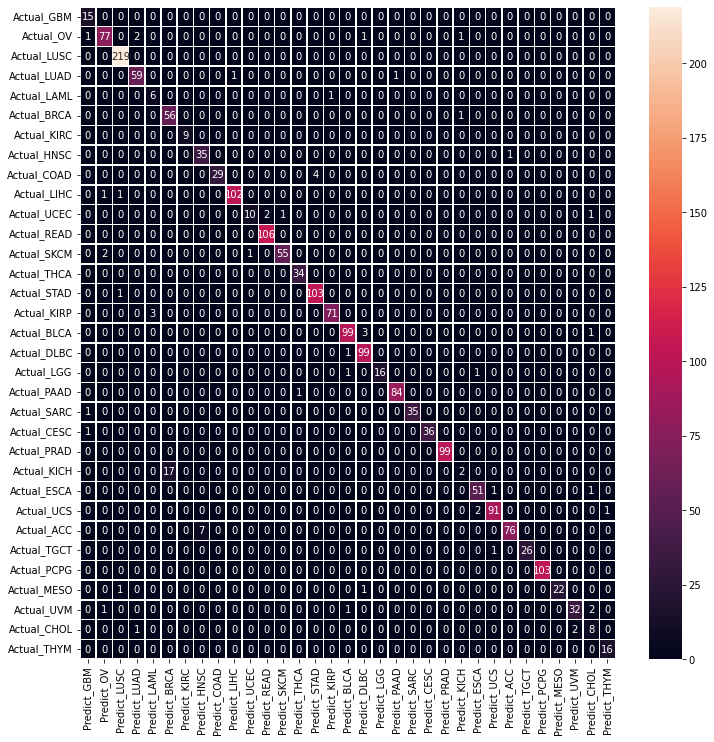

In [ ]:
plot_conf_matrix(cm4,y_test_4)

In [ ]:
# make predictions for test data
predictions_4 = [round(value) for value in y_pred_4]
# evaluate predictions
accuracy_4 = accuracy_score(y_test_4, predictions_4)
print("Accuracy: %.2f%%" % (accuracy_4 * 100.0))

# precision tp / (tp + fp)
# precision = precision_score(y_test, predictions, average=None)
# print('Precision for every class: %f' % precision.astype(str))
precision_4 = precision_score(y_test_4, predictions_4, average='micro')
print('Precision for all class: %f' % precision_4)

# recall: tp / (tp + fn)
recall_4 = recall_score(y_test_4, predictions_4,average='micro')
print('Recall: %f' % recall_4)
# f1: 2 tp / (2 tp + fp + fn)
f1_4 = f1_score(y_test_4, predictions_4, average='micro')
print('F1 score: %f' % f1_4)

Accuracy: 96.12%
Precision for all class: 0.961165
Recall: 0.961165
F1 score: 0.961165


# 5

In [63]:
test_split_5= pd.read_csv("./test_split_5.csv", sep=',')
test_split_5

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,4.6759,2.4960,3.4609,-4.6082,9.7135,5.7955,1.3109,1.0293,-3.0469,1.3567,...,1.9490,-3.0469,-3.0469,1.7273,4.9691,-9.9658,8,63,0,5
1,5.8829,3.0252,3.3119,-6.5064,9.4547,5.4900,1.4174,-1.4305,-1.8836,1.8801,...,1.4011,-5.0116,-0.3383,3.7561,5.0184,-9.9658,8,55,0,5
2,5.8199,2.8076,3.9031,-6.5064,9.2346,5.6787,0.6425,-0.3383,-2.3147,3.0110,...,1.4120,-4.6082,2.2330,4.2111,5.2877,-9.9658,8,31,1,2
3,5.3162,4.2758,3.4437,-5.5735,9.8965,5.6303,0.4447,-1.0559,-0.4921,1.9564,...,1.8363,-5.0116,-5.5735,3.4411,5.1148,-9.9658,8,58,1,5
4,5.1339,2.9186,3.5299,-3.6259,9.6870,5.7436,3.0446,1.7446,-0.4131,2.0638,...,1.5013,-3.4580,1.1184,1.9377,4.1555,-9.9658,8,57,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,3.3535,-0.2159,3.1095,-9.9658,9.4021,4.2743,-5.5735,-4.2934,-1.7322,-0.2159,...,0.8647,6.3266,-0.6416,-0.2159,3.3307,-9.9658,15,50,1,5
1952,3.5262,0.6699,2.4359,-9.9658,8.7991,3.8330,-3.3076,-2.9324,0.1257,-1.8314,...,2.0183,5.8352,-2.2447,-0.5332,3.4384,-9.9658,15,41,1,5
1953,6.0219,-0.1665,2.6962,-4.0350,12.3251,3.7720,-0.9971,-1.5105,-1.9379,-0.9686,...,-1.5522,-2.4659,-0.4921,2.9729,6.6918,-9.9658,29,59,0,5
1954,5.0631,2.9784,3.5212,-5.5735,9.6838,5.0466,1.3956,-2.1140,-1.4699,0.3231,...,1.4704,-0.1031,-5.5735,2.4386,4.8530,-9.9658,4,38,1,5


In [64]:
test_split_5_dummies = test_split_5.copy()
test_split_5_dummies = pd.get_dummies(test_split_5_dummies)

X_test_5 = test_split_5_dummies.drop(columns_to_drop, axis=1).copy()
y_test_5 = test_split_5_dummies['cancer type abbreviation'].copy()

In [65]:
train_split_5= pd.read_csv("./train_split_5.csv", sep=',')
# train_split_1

In [66]:
train_split_5_dummies = train_split_5.copy()
train_split_5_dummies = pd.get_dummies(train_split_5_dummies)

X_train_5 = train_split_5_dummies.drop(columns_to_drop, axis=1).copy()
y_train_5 = train_split_5_dummies['cancer type abbreviation'].copy()

In [67]:
cnn_model_5 = model

In [68]:
with tf.device('/GPU:0'):
    training_history = cnn_model_5.fit(X_train_5, y_train_5, batch_size=64, 
          epochs=200, validation_split=0.2, shuffle = True, callbacks=callbacks_list)

Epoch 1/200
98/98 [==============================] - 45s 462ms/step - loss: 0.0504 - accuracy: 0.9888 - val_loss: 3.0910 - val_accuracy: 0.8084 - lr: 1.0000e-16
Epoch 2/200
98/98 [==============================] - 46s 465ms/step - loss: 0.0528 - accuracy: 0.9882 - val_loss: 3.0578 - val_accuracy: 0.8084 - lr: 1.0000e-16
Epoch 3/200
98/98 [==============================] - 45s 458ms/step - loss: 0.0450 - accuracy: 0.9898 - val_loss: 3.0466 - val_accuracy: 0.8084 - lr: 1.0000e-16
Epoch 4/200
98/98 [==============================] - 45s 462ms/step - loss: 0.0484 - accuracy: 0.9891 - val_loss: 3.0677 - val_accuracy: 0.8078 - lr: 1.0000e-16
Epoch 5/200
98/98 [==============================] - 46s 468ms/step - loss: 0.0485 - accuracy: 0.9901 - val_loss: 3.0383 - val_accuracy: 0.8078 - lr: 1.0000e-16
Epoch 6/200
98/98 [==============================] - 46s 469ms/step - loss: 0.0540 - accuracy: 0.9887 - val_loss: 3.0370 - val_accuracy: 0.8084 - lr: 1.0000e-16
Epoch 7/200
98/98 [===============

In [69]:
cnn_model_5.save('Stratified_1DCNN_5' + '.h5')

In [70]:
scoreSeg5 = cnn_model_5.evaluate(X_test_5, y_test_5, verbose= False)
print("Accuracy = ",scoreSeg5[1])

Accuracy =  0.9279140830039978


In [93]:
y_pred_5 = cnn_model_5.predict(X_test_5)

# cm2=(confusion_matrix(y_test_5, y_pred_5))

62/62 [==============================] - 4s 60ms/step


In [94]:
print(classification_report(y_test_5, np.argmax(y_pred_5, axis = 1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.99      0.96      0.97        81
           2       1.00      1.00      1.00       219
           3       0.90      0.92      0.91        61
           4       0.00      0.00      0.00         7
           5       1.00      0.98      0.99        58
           6       1.00      1.00      1.00         9
           7       0.51      0.97      0.67        36
           8       1.00      1.00      1.00        33
           9       0.97      0.94      0.96       104
          10       0.65      1.00      0.79        13
          11       0.97      0.99      0.98       106
          12       0.97      0.97      0.97        58
          13       1.00      1.00      1.00        35
          14       0.96      1.00      0.98       105
          15       0.93      1.00      0.96        74
          16       0.95      1.00      0.98       103
          17       0.99    

/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_conf_matrix(cm5, y_test_5)

In [ ]:
# make predictions for test data
predictions_5 = [round(value) for value in y_pred_5]
# evaluate predictions
accuracy_5 = accuracy_score(y_test_5, predictions_5)
print("Accuracy: %.2f%%" % (accuracy_5 * 100.0))

# precision tp / (tp + fp)
# precision = precision_score(y_test, predictions, average=None)
# print('Precision for every class: %f' % precision.astype(str))
precision_5 = precision_score(y_test_5, predictions_5, average='micro')
print('Precision for all class: %f' % precision_5)

# recall: tp / (tp + fn)
recall_5 = recall_score(y_test_5, predictions_5,average='micro')
print('Recall: %f' % recall_5)
# f1: 2 tp / (2 tp + fp + fn)
f1_5 = f1_score(y_test_5, predictions_5, average='micro')
print('F1 score: %f' % f1_5)

Accuracy: 95.25%
Precision for all class: 0.952454
Recall: 0.952454
F1 score: 0.952454


In [ ]:
!cp -r '/content/tumor_xgb_model_sort_5' /content/gdrive/MyDrive/gene_seq/

# avg accuracy

In [77]:
avg_acc=(scoreSeg1[1]+scoreSeg2[1]+scoreSeg3[1]+scoreSeg4[1]+scoreSeg5[1])/5
avg_acc

0.9450105190277099

In [ ]:
cm=cm1+cm2+cm3+cm4+cm5

In [ ]:
def plot_conf_matrix(cm, y_test):
    labels=y_test.unique()
    cancer_names=[]
    for i in labels:
        if i in cancer_name_num_dict.keys():
            cancer_names.append(cancer_name_num_dict[i])
    
    column= [f'Predict_{cancer_name}' for cancer_name in cancer_names]
    indices= [f'Actual_{cancer_name}' for cancer_name in cancer_names]
    
    table= pd.DataFrame(cm, columns=column, index=indices)
    
    fig, ax = pyplot.subplots(figsize=(12,12))         # Sample figsize in inches

    return sn.heatmap(table, annot=True, fmt="d",  linewidths=.5, ax=ax)

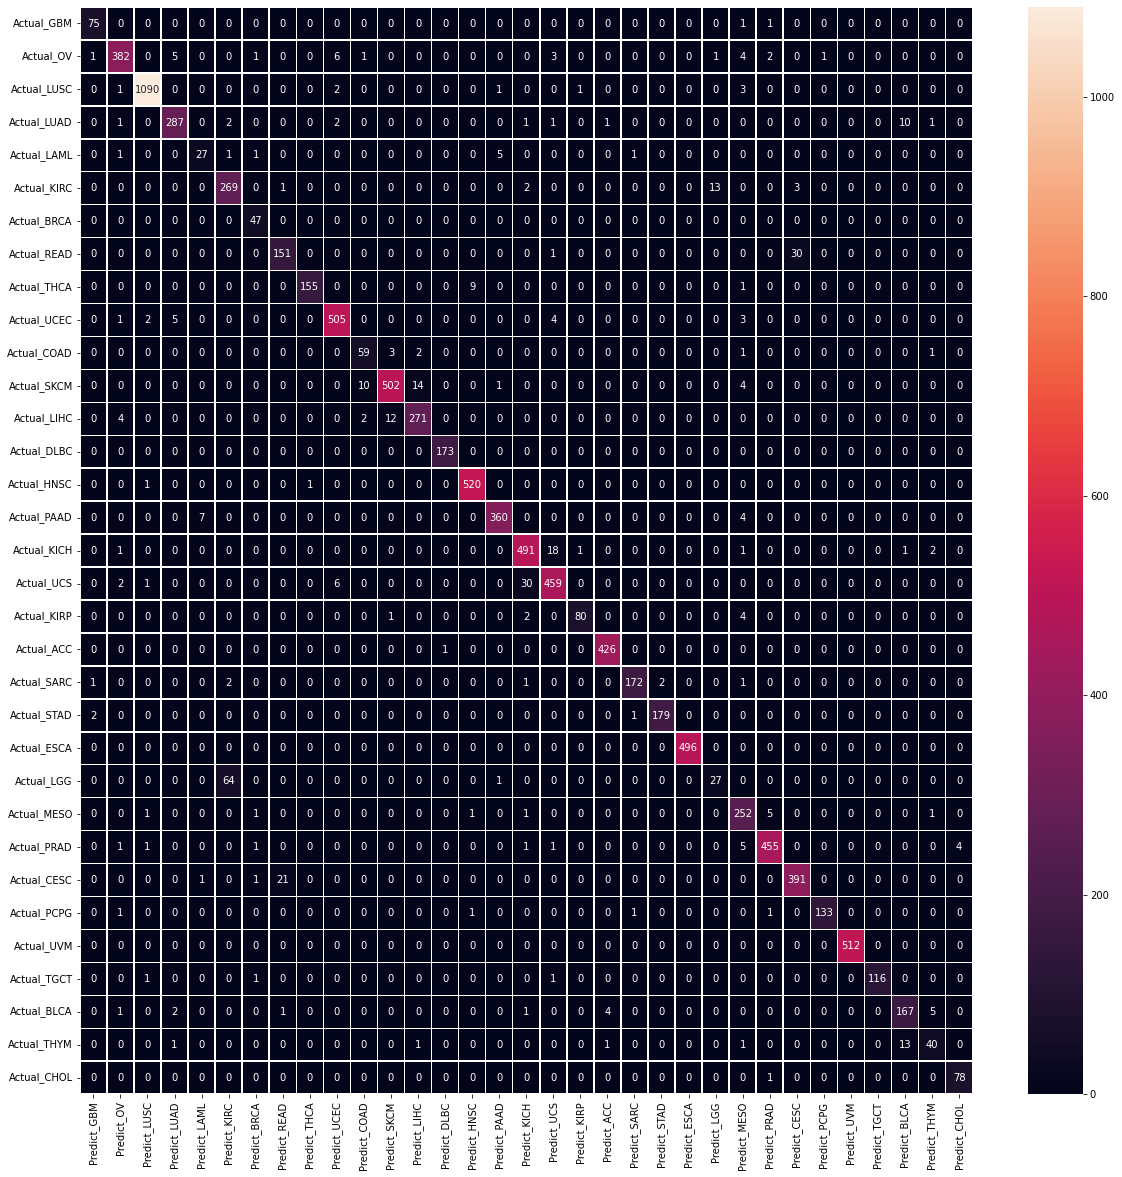

In [ ]:
plot_final_conf_matrix(cm, y_test_5)